In [2]:
# Practising CNN using CIFAR Dataset

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn
from torch import optim
import numpy as np

In [4]:
# Defining some parameters for training and validation data:

# Batch Size
batch_size = 20

# % of Validation Set
valid_pct = 0.2

In [5]:
transforms = transforms.Compose([transforms.ToTensor()])

trainset = datasets.CIFAR10('data', download=True, train=True, transform=transforms)
testset = datasets.CIFAR10('data', download=True, train=False, transform=transforms)


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [6]:
len_trainset = len(trainset)
indices = list(range(len_trainset))
np.random.shuffle(indices)
split = int(valid_pct*len_trainset)

train_idx , valid_idx = indices[split:], indices[:split]

In [7]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [8]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size)

In [9]:
classes = ['airplane', "automobile", "bird ", "cat", "deer", "dog", "frog", "horse", "ship" ,"truck"]

In [10]:
# Function to help visualizing the images
%matplotlib inline

def img_helper(img):
    # Un-Normalizing the image
    img = img/2 + 0.5 
    plt.imshow(np.transpose(img, (1,2,0)))


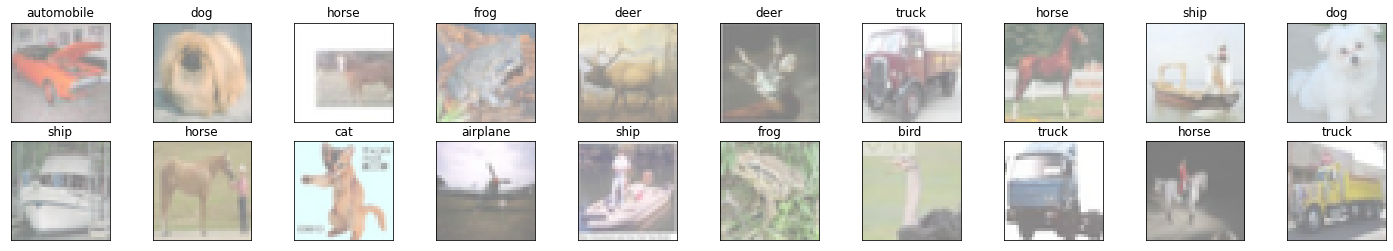

In [11]:
images, labels = next(iter(trainloader))
fig = plt.figure(figsize = (25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks = [])
    img_helper(images[idx])
    ax.set_title(classes[labels[idx]])

In [12]:
### Defining the Network Architecture

In [13]:
class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # Input Image is of sixe : 3*32*32
        
        # After first Conovultional and Pooling Layer Image size : 16*16*16 (Since X-Y dimensions get reduced by a factor of 2 and Depth is increased to 16)
        self.conv1 = nn.Conv2d(3, 16, 3,  padding=1)
        # After Second C&P Layers : 64*8*8
        self.conv2 = nn.Conv2d(16, 64, 3, padding=1)
        # After Third C&P Layers : 256*4*4
        self.conv3 = nn.Conv2d(64, 256, 3, padding=1)
        
        
        self.fc1 = nn.Linear(256*4*4, 1000)
        self.fc2 = nn.Linear(1000, 10)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.dropout = nn.Dropout( p = 0.2)
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
    
        # Compressing the Image into a vector so that it can be passed to the Linear Fully Connected Layers
        x = x.view(-1, 256*4*4)
        x = self.dropout(x)
        x = self.dropout(F.relu(self.fc1(x)))
        
        x = (self.fc2(x))
        
        return x

In [14]:
model = Network()
model

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [15]:
### Training the Model

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [17]:
epochs = 30


valid_loss_min = float("inf")
    
for iterations in range(epochs):

    train_loss = 0
    validation_loss = 0
    
    
    # Training the model
    model.train()
    for images, labels in trainloader:

        optimizer.zero_grad()
        
        preds = model(images)
        
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)
        
        
    
    # Validating the model
    model.eval()
    for images_v, labels_v in validloader:
            
        preds_v = (model.forward(images_v))
        loss = criterion(preds_v, labels_v)
        validation_loss += loss.item() * images_v.size(0)
    
    # Average Loss:
    train_loss = train_loss/ len(trainloader.sampler)
    validation_loss = validation_loss/ len(validloader.sampler)


    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        iterations, train_loss, validation_loss))
        
    # Saving the model if Validation Loss has decreased
    
    if validation_loss < valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), "cnn_CIFAR.pt")
        valid_loss_min = validation_loss
        print("\n")            
        
        
        

Epoch: 0 	Training Loss: 2.151229 	Validation Loss: 1.957538
Validation loss decreased (inf --> 1.957538).  Saving model ...


Epoch: 1 	Training Loss: 1.766315 	Validation Loss: 1.627915
Validation loss decreased (1.957538 --> 1.627915).  Saving model ...


Epoch: 2 	Training Loss: 1.531364 	Validation Loss: 1.424104
Validation loss decreased (1.627915 --> 1.424104).  Saving model ...


Epoch: 3 	Training Loss: 1.396040 	Validation Loss: 1.312232
Validation loss decreased (1.424104 --> 1.312232).  Saving model ...


Epoch: 4 	Training Loss: 1.278107 	Validation Loss: 1.219820
Validation loss decreased (1.312232 --> 1.219820).  Saving model ...


Epoch: 5 	Training Loss: 1.168382 	Validation Loss: 1.168573
Validation loss decreased (1.219820 --> 1.168573).  Saving model ...


Epoch: 6 	Training Loss: 1.071061 	Validation Loss: 1.016854
Validation loss decreased (1.168573 --> 1.016854).  Saving model ...


Epoch: 7 	Training Loss: 0.986345 	Validation Loss: 0.969841
Validation loss decr

In [19]:
model.load_state_dict(torch.load('cnn_CIFAR.pt'))

<All keys matched successfully>

In [23]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available

    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.774197

Test Accuracy of airplane: 81% (816/1000)
Test Accuracy of automobile: 83% (833/1000)
Test Accuracy of bird : 62% (627/1000)
Test Accuracy of   cat: 53% (530/1000)
Test Accuracy of  deer: 66% (668/1000)
Test Accuracy of   dog: 66% (660/1000)
Test Accuracy of  frog: 78% (788/1000)
Test Accuracy of horse: 87% (874/1000)
Test Accuracy of  ship: 85% (856/1000)
Test Accuracy of truck: 77% (778/1000)

Test Accuracy (Overall): 74% (7430/10000)
